In [1]:
from dolfin import *
import numpy as np

Consider the following stream function
$$
\psi(r,\theta,z) = \frac{1}{2}r^2\left(1-{r^2}-4{z^2}\right).
$$
This function generates eliptical vortex. The induced velocity in cylindrical coordinates is given below
$$
\frac{dr}{dt}=-\frac{1}{r}\frac{\partial\psi}{\partial z}=4rz\\
\frac{dz}{dt}=\frac{1}{r}\frac{\partial\psi}{\partial r}=1-2r^2-4z^2\\
\frac{d\theta}{dt}=0
$$
To obtain well-defined stream surfaces, we add rigid body notation as below
$$
\frac{d\theta}{dt}=\Omega
$$

The velocity components in Cartesian coordiantes are given as below
$$
u_x = \dot{r}\cos\theta-r\sin\theta\dot{\theta} = 4xz-y\Omega,\\
u_y = \dot{r}\sin\theta+r\cos\theta\dot{\theta} = 4yz+x\Omega,\\
u_z = 1-2(x^2+y^2)-4z^2.
$$

Again, the constructed stream function is a solution to first integral.

In [2]:
def eigenvalues(X, V):
#
    # Define the bilinear forms on the right- and left-hand sides
    H = TrialFunction(V)
    h = TestFunction(V)
    a = (inner(X,grad(H))*inner(X, grad(h)))*dx #+inner(H,h)*dx - shift zero eigenvalue
    b = inner(H,h)*dx
#
    # Assemble into PETSc matrices
    A = PETScMatrix()
    assemble(a, tensor=A)
    B = PETScMatrix()
    assemble(b, tensor=B)
#
    solver = SLEPcEigenSolver(A, B)
    solver.parameters["solver"] = "krylov-schur" # "lapack" # "lanczos" # "krylov-schur" - not good for high-fidelty discretization
    solver.parameters["problem_type"] = "gen_hermitian"
    #solver.parameters["maximum_iterations"] = 10000
    #solver.parameters['tolerance'] = 1.e-14
    solver.parameters["spectrum"] = "target magnitude"
    solver.parameters["spectral_transform"] = "shift-and-invert"
    solver.parameters["spectral_shift"] = -0.1 # 0 is not working, 1e-14 or negative number (-0.1) works fine
    
    neigs = 4
    solver.solve(neigs)
    # print("number of iterations is ",solver.get_iteration_number())
    print("number of converged eigenvalues: ",solver.get_number_converged())
#
    # Return the computed eigenvalues in a sorted array
    computed_eigenvalues = []
    for i in range(min(neigs, solver.get_number_converged())):
        r, _ = solver.get_eigenvalue(i) # ignore the imaginary part
        computed_eigenvalues.append(r)
        print("eigenvalue: ", r)
    # Return the H corresponding to the first and second eigenvalue
    print("return the first eienvector")
    r, c, rx, cx = solver.get_eigenpair(0)
    # Turn the eigenvector into a Function:
    rx_func0 = Function(V)
    rx_func0.vector()[:] = rx
    print("return the second eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func1 = Function(V)
    rx_func1.vector()[:] = rx
    print("return the third eienvector")
    r, c, rx, cx = solver.get_eigenpair(1)
    # Turn the eigenvector into a Function:
    rx_func2 = Function(V)
    rx_func2.vector()[:] = rx
    
    return np.array(computed_eigenvalues), rx_func0, rx_func1, rx_func2


In [3]:
def objective(X,H,V):
    x0 = project(X[0],V,solver_type='iterative')
    x1 = project(X[1],V,solver_type='iterative')
    x2 = project(X[2],V,solver_type='iterative')
    gh = grad(H)
    err_grand = x0*gh[0]+x1*gh[1]+x2*gh[2] 
    res = (err_grand*err_grand)*dx
    res = np.sqrt(assemble(res))
    print('residual in L2 norm is',res)
    return res


In [4]:
def plot_results(rhosamp,thetasamp,zsamp,dirname,H1,Href,mode):
    from matplotlib import pyplot as plt
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    nz   = np.size(zsamp)
    Rhosamp = np.concatenate((-np.flipud(rhosamp),rhosamp))
    RHO,Z   = np.meshgrid(Rhosamp,zsamp)
    yy = RHO
    zz = Z
    hx1 = H1[:,np.argmin(abs(thetasamp-0.5*pi)),:]
    hx1 = np.reshape(hx1,[nrho,nz])
    hx2 = H1[:,np.argmin(abs(thetasamp-1.5*pi)),:]
    hx2 = np.reshape(hx2,[nrho,nz])
    hx2 = np.flipud(hx2)
    hx  = np.concatenate((hx2,hx1))
    plt.figure()
    plt.contour(yy,zz,hx.T,100)
    plt.colorbar()   
    plt.title('x=0 '+'mode'+str(mode))
    plt.savefig(dirname+'/x'+'mode'+str(mode)+'.png')
    hxref1 = Href[:,np.argmin(abs(thetasamp-0.5*pi)),:]
    hxref1 = np.reshape(hxref1,[nrho,nz])
    hxref2 = Href[:,np.argmin(abs(thetasamp-1.5*pi)),:]
    hxref2 = np.reshape(hxref2,[nrho,nz])
    hxref2 = np.flipud(hxref2)
    hxref  = np.concatenate((hxref2,hxref1))
    plt.figure()
    plt.contour(yy,zz,hxref.T,100)
    plt.colorbar()   
    plt.title('x=0 (reference)')
    plt.savefig(dirname+'/xref.png')    

    
    xx = RHO
    zz = Z
    hy1 = H1[:,np.argmin(abs(thetasamp-0)),:]
    hy1 = np.reshape(hy1,[nrho,nz])
    hy2 = H1[:,np.argmin(abs(thetasamp-pi)),:]
    hy2 = np.reshape(hy2,[nrho,nz])
    hy2 = np.flipud(hy2)
    hy  = np.concatenate((hy2,hy1))
    plt.figure()
    plt.contour(xx,zz,hx.T,100)
    plt.colorbar()   
    plt.title('y=0 '+'mode'+str(mode))
    plt.savefig(dirname+'/y'+'mode'+str(mode)+'.png')
    hyref1 = Href[:,np.argmin(abs(thetasamp-0)),:]
    hyref1 = np.reshape(hyref1,[nrho,nz])
    hyref2 = Href[:,np.argmin(abs(thetasamp-pi)),:]
    hyref2 = np.reshape(hyref2,[nrho,nz])
    hyref2 = np.flipud(hyref2)
    hyref  = np.concatenate((hyref2,hyref1))
    plt.figure()
    plt.contour(xx,zz,hyref.T,100)
    plt.colorbar()   
    plt.title('y=0 (reference)')
    plt.savefig(dirname+'/yref.png') 
    
    hz = H1[:,:,np.argmin(abs(zsamp-0.))]
    hz = np.reshape(hz,[nrho,nth])
    RHO,TH=np.meshgrid(rhosamp,thetasamp)
    xx = RHO*np.cos(TH)
    yy = RHO*np.sin(TH)
    plt.figure();
    plt.contour(xx,yy,hz.T,100)
    plt.colorbar()
    plt.title('z=0 '+'mode'+str(mode))
    plt.savefig(dirname+'/z'+'mode'+str(mode)+'.png')
    hzref = Href[:,:,np.argmin(abs(zsamp-0.))]
    hzref = np.reshape(hzref,[nrho,nth])
    plt.figure();
    plt.contour(xx,yy,hzref.T,100)
    plt.colorbar()
    plt.title('z=0 (reference)')
    plt.savefig(dirname+'/zref.png')

In [5]:
def print_eigenvalues_save_solutions(X,mesh,order,ngrids,rhosamp,thetasamp,zsamp,coef):
#
    # V = FunctionSpace(mesh, "Lagrange", order, constrained_domain=pbc)
    V = FunctionSpace(mesh, "Lagrange", order)
    lamd,eiv0,eiv1,eiv2 = eigenvalues(X,V)
    np.set_printoptions(formatter={'float': '{:5.2f}'.format})
    print("Eigenvales:  {}".format(lamd))
#
    # demonstrate the first eigensolution corresponds to constant solution
    print("The first eigensolution is expected to be constant")
    nrho = np.size(rhosamp)
    nth  = np.size(thetasamp)
    nz   = np.size(zsamp)
    H0 = np.zeros((nrho,nth,nz))
    for i in range(nrho):
        for j in range(nth):
            for k in range(nz):
                xp = rhosamp[i]*np.cos(thetasamp[j])
                yp = rhosamp[i]*np.sin(thetasamp[j])
                zp = zsamp[k]
                H0[i,j,k] = eiv0(xp,yp,zp)
    h0 = H0.flatten()
    dh0 = max(h0)-min(h0)
    print("range of H0: ", dh0)
#
    # plot of the second eigensolution and save solution
    print("Plot and store the second eigensolution")
    H1 = np.zeros((nrho,nth,nz))
    H2 = np.zeros((nrho,nth,nz))
    Href = np.zeros((nrho,nth,nz))
    for i in range(nrho):
        for j in range(nth):
            for k in range(nz):
                xp = rhosamp[i]*np.cos(thetasamp[j])
                yp = rhosamp[i]*np.sin(thetasamp[j])
                zp = zsamp[k]             
                H1[i,j,k] = eiv1(xp,yp,zp)
                H2[i,j,k] = eiv2(xp,yp,zp)
                rsquare = xp*xp+yp*yp
                Href[i,j,k] = 0.5*rsquare*(1-4*zp*zp-rsquare)
    h1 = H1.flatten()
    dh1 = max(h1)-min(h1)
    print("range of H1: ", dh1)
    import os
    dirname = 'cylinderDomain'+'Ngrids'+str(ngrids)+'Order'+str(order)+'Om'+coef
    isFile = os.path.isdir(dirname) 
    if not isFile:
        os.mkdir(dirname)
#
    # contour plot of H at sections x=0, y=0 and z=0
    plot_results(rhosamp,thetasamp,zsamp,dirname,H1,Href,1)
    # plot_results(rhosamp,thetasamp,psisamp,dirname,H2,Href,2)
    # res = objective(X,eiv1,V)
#    
    # save solution as matlab compatible file
    mdic = {"rho": rhosamp,"theta": thetasamp,"z": zsamp,"lambda": lamd,"H": H1,"Href": Href,"numDOF": V.dim(),"numEle": mesh.num_cells()}
    from scipy.io import savemat
    savemat(dirname,mdic)
    

***************************************************
computation at order 2 and 10 grid points
number of converged eigenvalues:  8
eigenvalue:  -1.942890293094024e-16
eigenvalue:  0.029661606225899972
eigenvalue:  0.09317803465856972
eigenvalue:  0.09381329255608062
return the first eienvector
return the second eienvector
return the third eienvector
Eigenvales:  [-0.00  0.03  0.09  0.09]
The first eigensolution is expected to be constant
range of H0:  2.2000179456e-12
Plot and store the second eigensolution
range of H1:  3.70671372479
***************************************************
computation at order 2 and 20 grid points
number of converged eigenvalues:  6
eigenvalue:  5.76899639170847e-14
eigenvalue:  0.0024893450490763025
eigenvalue:  0.019151661842140122
eigenvalue:  0.019697781049086677
return the first eienvector
return the second eienvector
return the third eienvector
Eigenvales:  [ 0.00  0.00  0.02  0.02]
The first eigensolution is expected to be constant
range of H0:  1.20

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:64: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`)

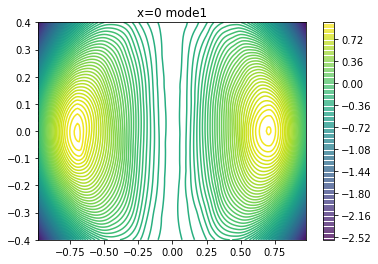

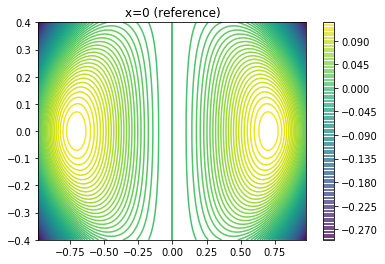

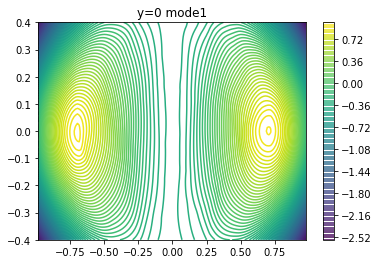

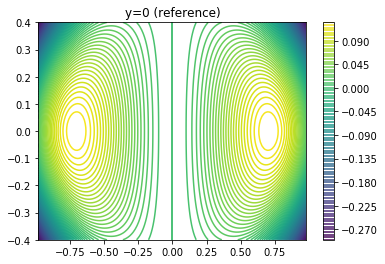

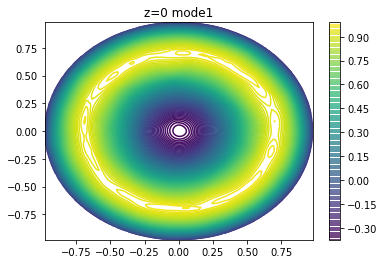

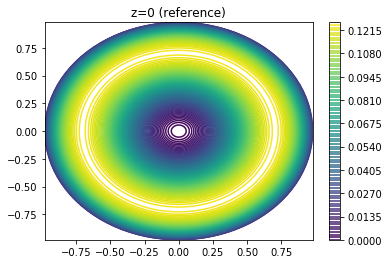

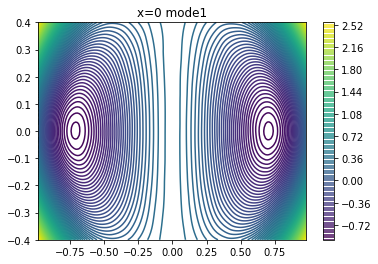

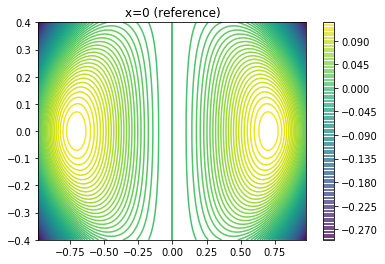

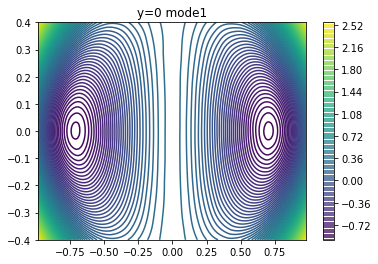

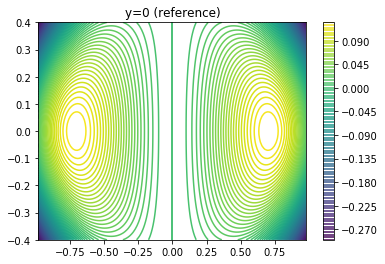

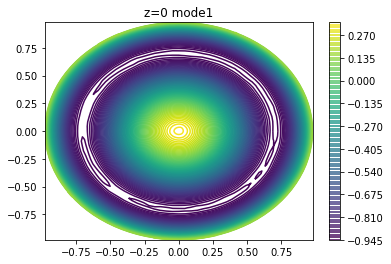

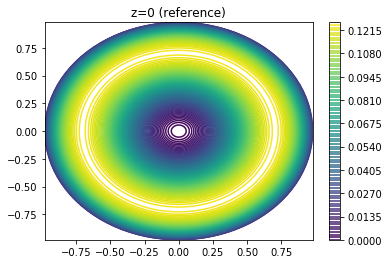

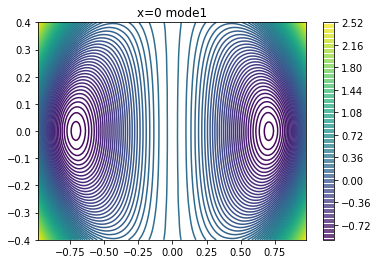

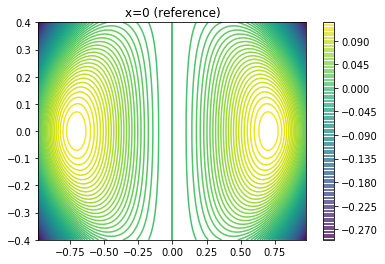

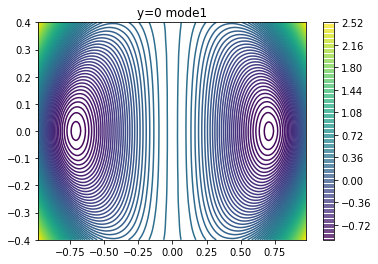

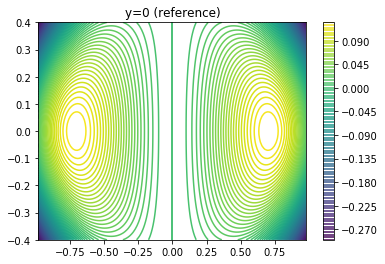

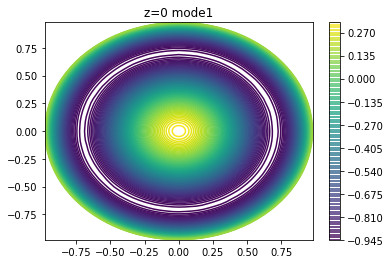

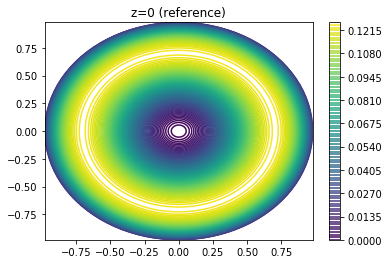

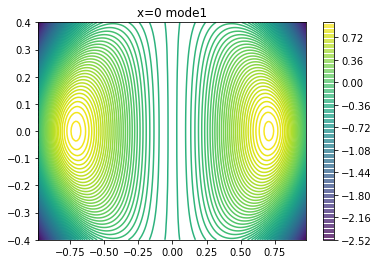

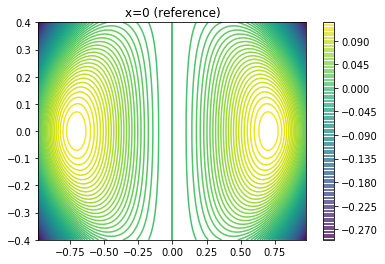

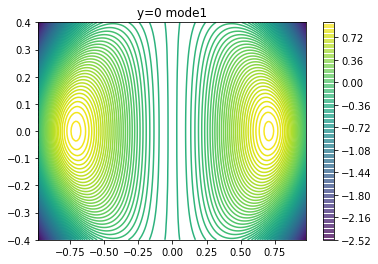

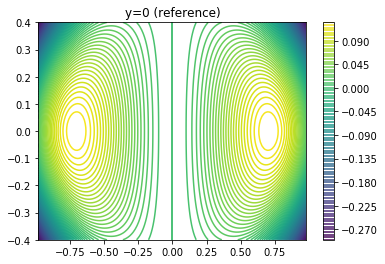

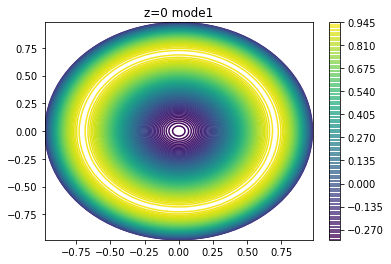

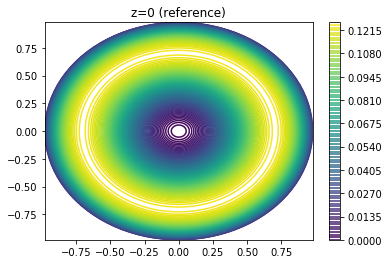

In [6]:
# set up problem
from mshr import *
order = 2
numGrids = np.array([10, 20, 30, 40])
a = 1.0
rhosamp   = np.linspace(0,0.98,80) # evaluation of H for plotting
thetasamp = np.linspace(0,2*pi,101) 
zsamp     = np.linspace(-0.4,0.4,61) 
cylinder  = Cylinder(Point(0,0,-0.4),Point(0,0,0.4),1,1)
Om = '1'
x1 = '4*x[0]*x[2]-1.0*x[1]'
x2 = '4*x[1]*x[2]+1.0*x[0]'
x3 = '1-2*(x[0]*x[0]+x[1]*x[1])-4*x[2]*x[2]'
X = Expression((x1,x2,x3),degree=order)
# loop over number of grids
for idx in numGrids:
    print('***************************************************')
    print('computation at order',order,'and',idx,'grid points')
    ngrid = idx
    mesh  = generate_mesh(cylinder,ngrid)
    print_eigenvalues_save_solutions(X,mesh,order,ngrid,rhosamp,thetasamp,zsamp,Om)

In [7]:
mesh

In [8]:
mesh.num_cells()

72391